# Garbage Classification using EfficientNetV2B2

### Project Description
This project builds a garbage classification system using EfficientNetV2B2 and transfer learning.
The model is trained to identify different waste categories accurately. Performance is validated using accuracy metrics and visual evaluation tools.
### Goal:
The goal is to automate waste sorting and support efficient recycling.
### Challenges and Scope
Key Challenge: A challenge encountered is the inherent class imbalance within the dataset.
Benefits: Efficiently classifies imbalanced garbage datasets by reusing high-quality features from large-scale models.

### Architecture used: EfficientNetV2B2
Chose because of its Balanced Performance, Scalable, Pretrained on ImageNet & Efficient nature.
### Core Libraries used:
tensorflow, numpy, matplotlib.pyplot.

In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive

## 1. Explore and Understand the Data

In [2]:
#Load image dataset using tools like image_dataset_from_directory.

dataset_dir= r"C:\Users\91914\Downloads\new_dataset\us this data"
image_size = (124, 124)
batch_size = 32
seed = 42

In [3]:
#Split data into training, validation, and testing sets.

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 3600 files belonging to 6 classes.
Using 2880 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names


Found 3600 files belonging to 6 classes.
Using 720 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [6]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


## Visualize sample images from each class:

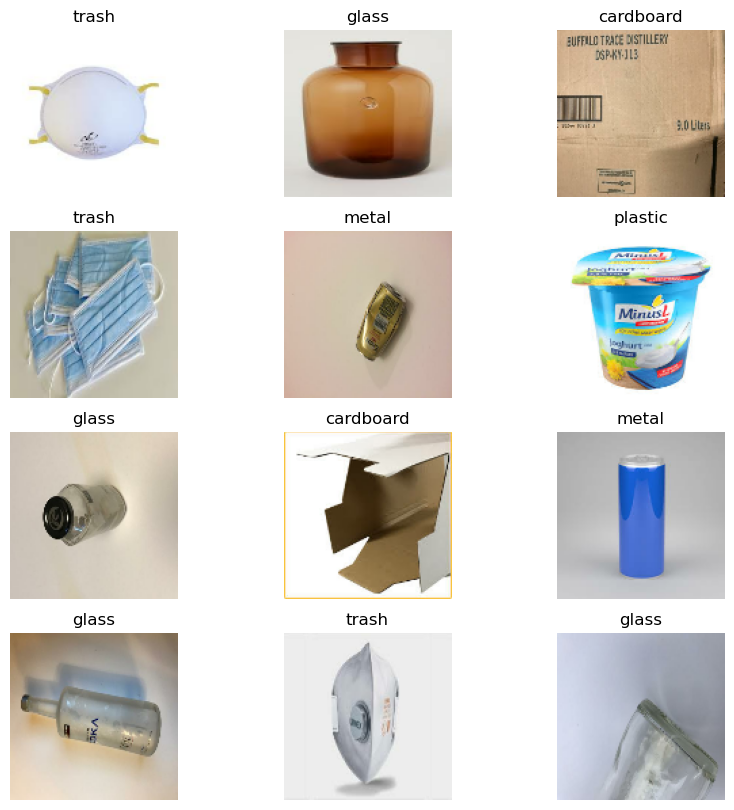

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

## Checking the number of images per class to ensure balance & understand image properties like Image dimensions, Class labels

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 17.36, 'glass': 16.15, 'metal': 16.6, 'paper': 17.19, 'plastic': 16.6, 'trash': 16.11}
{'cardboard': 13.89, 'glass': 18.75, 'metal': 16.94, 'paper': 14.58, 'plastic': 16.94, 'trash': 18.89}
{'cardboard': 16.19, 'glass': 19.89, 'metal': 16.48, 'paper': 13.07, 'plastic': 16.19, 'trash': 18.18}
{'cardboard': 15.62, 'glass': 17.45, 'metal': 16.77, 'paper': 15.89, 'plastic': 16.77, 'trash': 17.5}


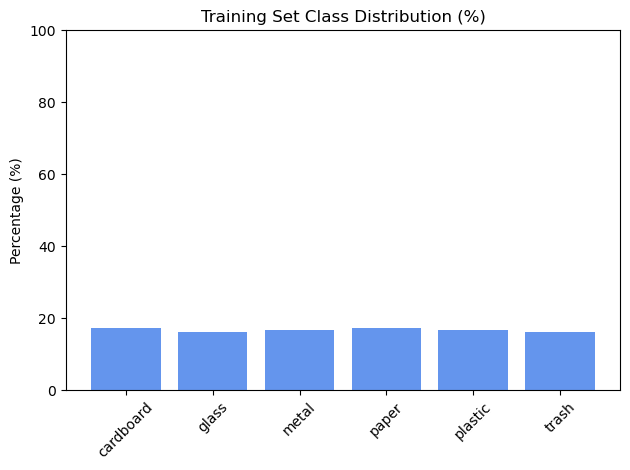

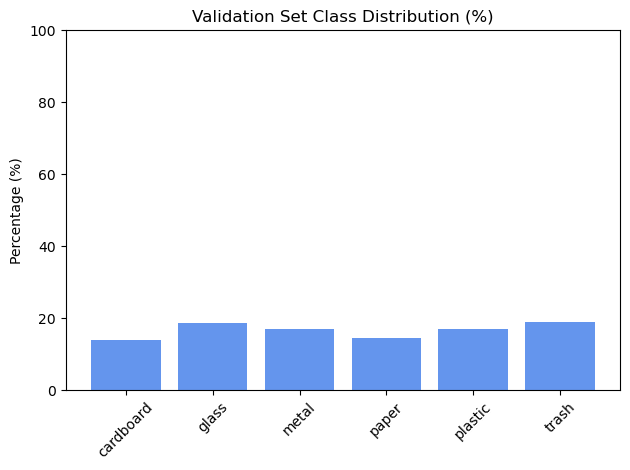

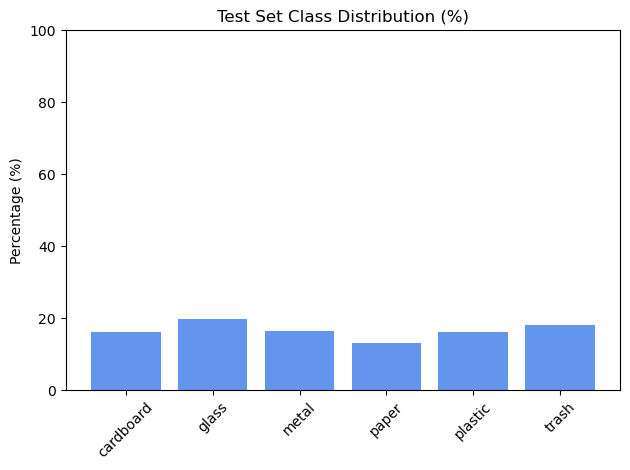

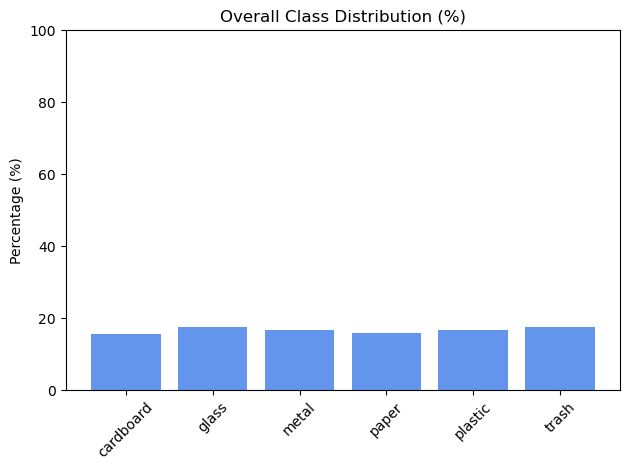

In [10]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [11]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 500, 1: 465, 2: 478, 3: 495, 4: 478, 5: 464}
Class Weights: {0: 0.96, 1: 1.032258064516129, 2: 1.00418410041841, 3: 0.9696969696969697, 4: 1.00418410041841, 5: 1.0344827586206897}


## 2. Data Preprocessing / Preparation

In [12]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

## 3. Model Selection

In [13]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

## 4. Model Training

In [14]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Model Tuning and Optimization

In [15]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [16]:
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.3645 - loss: 1.5940 - val_accuracy: 0.7917 - val_loss: 0.7942
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7695 - loss: 0.7475 - val_accuracy: 0.8750 - val_loss: 0.4448
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8411 - loss: 0.4818 - val_accuracy: 0.9083 - val_loss: 0.3098
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9146 - loss: 0.3038 - val_accuracy: 0.9236 - val_loss: 0.2532
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9335 - loss: 0.2359 - val_accuracy: 0.9264 - val_loss: 0.2296
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9428 - loss: 0.1826 - val_accuracy: 0.9389 - val_loss: 0.2040
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9506 - loss: 0.1482 - val_accuracy: 0.9389 - val_loss: 0.1861
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9677 - loss: 0.1232 - val_accuracy: 0.9431 - val_

In [17]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [18]:
base_model.summary() 

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 124, 124, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 124, 124, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 31, 31, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

## 6. Model Performance Visualization: Accuracy & Loss Trends

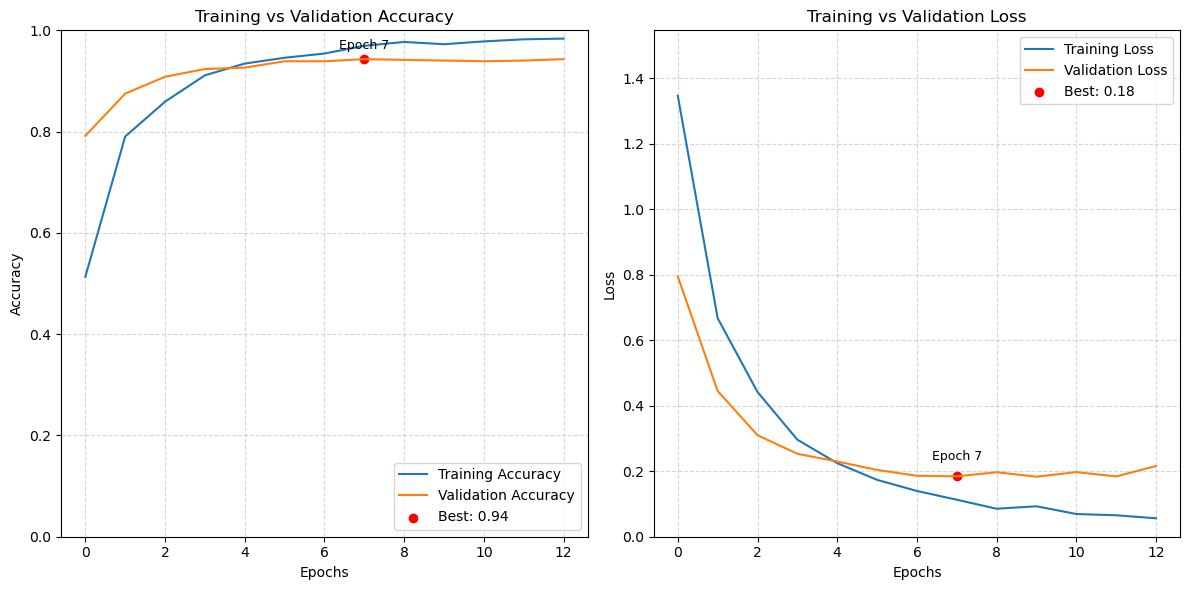

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Identify best epoch based on validation accuracy
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]
best_val_loss = val_loss[best_epoch]

# Create figure for the plots
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best: {best_val_acc:.2f}')
plt.text(best_epoch, best_val_acc + 0.02, f'Epoch {best_epoch}', ha='center', fontsize=9)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best: {best_val_loss:.2f}')
plt.text(best_epoch, best_val_loss + 0.05, f'Epoch {best_epoch}', ha='center', fontsize=9)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, max(max(loss), max(val_loss)) + 0.2])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

# Save and show plot
plt.tight_layout()
plt.savefig("metrics_plot.png", dpi=300)  # Optional: save the plot as PNG
plt.show()


In [20]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - accuracy: 0.9612 - loss: 0.1618
Test accuracy is0.9460, Test loss is 0.1975


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.9612 - loss: 0.1618
Test accuracy is 0.9460, Test loss is 0.1975
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step


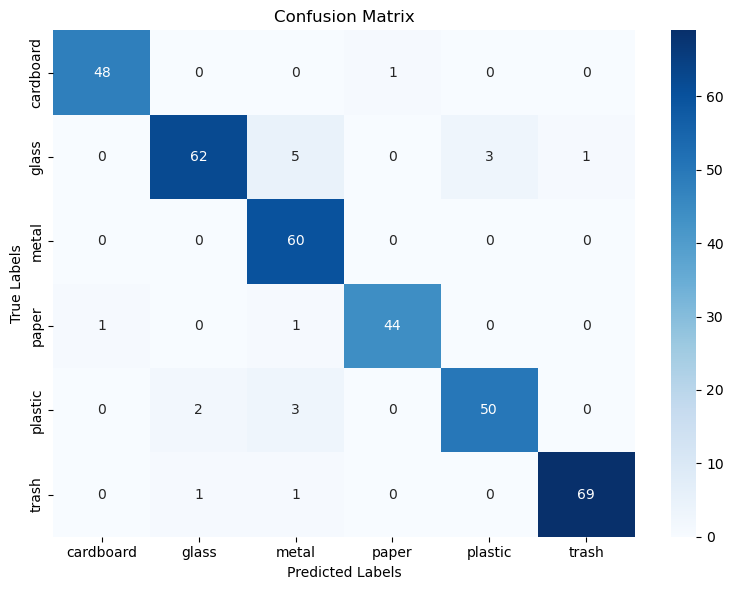

              precision  recall  f1-score  support
cardboard          0.98    0.98      0.98    49.00
glass              0.95    0.87      0.91    71.00
metal              0.86    1.00      0.92    60.00
paper              0.98    0.96      0.97    46.00
plastic            0.94    0.91      0.93    55.00
trash              0.99    0.97      0.98    71.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.95    0.95      0.95   352.00
weighted avg       0.95    0.95      0.95   352.00


In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ✅ Step 1: Evaluate model
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

# ✅ Step 2: Extract true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)

# ✅ Step 3: Get predicted probabilities
y_pred_probs = model.predict(test_ds_eval)

# ✅ Step 4: Convert to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Step 5: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.class_names,
            yticklabels=train_ds.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)  # Optional: save as PNG
plt.show()

# ✅ Step 6: Classification Report as DataFrame
report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=train_ds.class_names)
report_df = pd.DataFrame(report_dict).transpose().round(2)
print(report_df)

# ✅ Optional: Save report for future use
report_df.to_csv("classification_report.csv")


In [22]:
# ✅ Simple evaluation on validation dataset
val_loss, val_accuracy = model.evaluate(val_dat)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - accuracy: 0.9241 - loss: 0.2537
Validation Accuracy: 0.9348
Validation Loss: 0.1975


## 7. Final Testing and Save the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


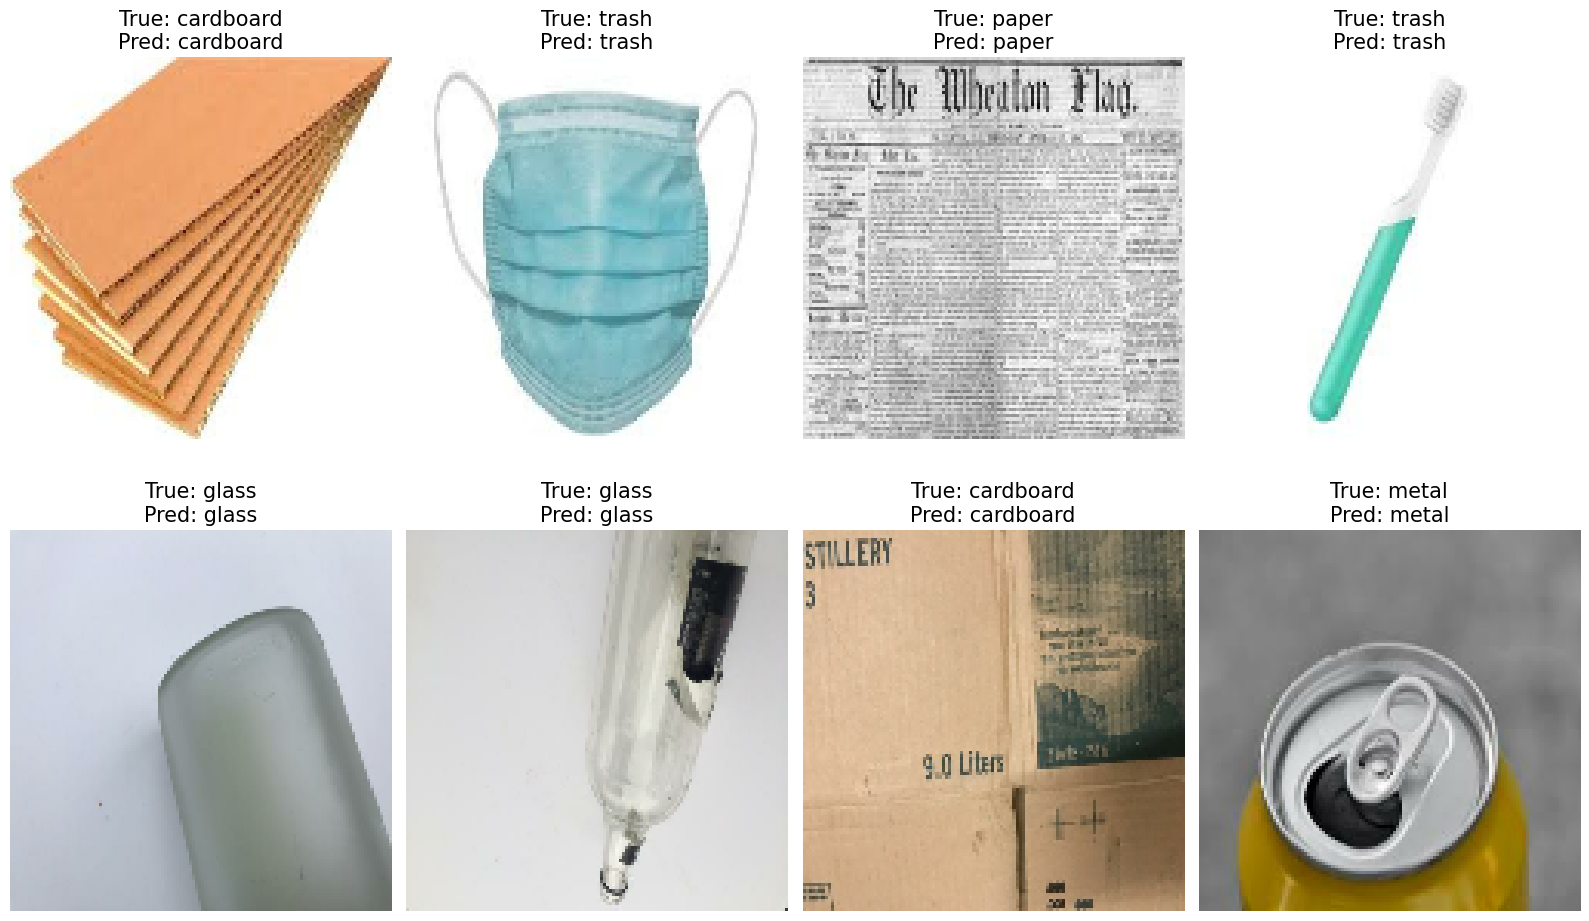

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Extract class names
class_names = train_ds.class_names  

# Take one batch from the test dataset
for images, labels in test_ds_eval.take(1):

    # Predict class probabilities for the batch
    predictions = model.predict(images)

    # Convert probabilities to predicted class indices
    pred_labels = tf.argmax(predictions, axis=1)

    # Plot first 8 samples with predictions
    plt.figure(figsize=(16, 10))  # Optional: bigger display
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns layout
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        predicted_label = class_names[pred_labels[i].numpy()]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=15)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [25]:
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [26]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable


In [27]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
# Define prediction function
def predict_image(img):
    img = img.resize((124, 124))                  # Resize to match model's input shape
    img_array = np.array(img) / 255.0              # Normalize
    img_array = img_array.reshape(1, 124, 124, 3)  # Add batch dimension
    prediction = model.predict(img_array)          # Predict probabilities
    class_idx = np.argmax(prediction)
    confidence = float(np.max(prediction))
    label = train_ds.class_names[class_idx]        # Map index to label
    return {label: confidence}
# Create Gradio interface
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Garbage Classifier",
    description="Upload an image to classify it into garbage categories using EfficientNetV2-B2"
)
# Launch
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Conclusion
The image classification model uses deep learning to deliver high-accuracy predictions, 
making it a dependable tool for identifying objects across diverse scenarios.